### Link to git repository:
https://github.com/Aaresh1705/CSS_project_final

### Link to website:
https://aaresh1705.github.io/CSS_project_final/

### Contributions:
| Name               | Motivation | Network stats | Indpeth network analysis | Discussion | Website |
|--------------------|------------|---------------|--------------------------|------------|---------|
| Mikkel (s234860)   | 0%         | 0%            | 0%                       | 0%         | 0%      |
| Kantinka (s235058) | 0%         | 0%            | 0%                       | 0%         | 0%      |
| Marcus (s234816)   | 0%         | 0%            | 0%                       | 0%         | 0%      |

# Final Project
### Musician community analysis in Denmark

In [ ]:
# Library imports
# Native libraries
import re
import ast
from itertools import chain
from collections import Counter
from itertools import combinations
import pickle

# Third party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as Patch
import networkx as nx
import requests
from bs4 import BeautifulSoup
#import discogs_client

In [ ]:
# Self-made function imports
from functions.loading_articles import get_music_articles
from functions.member_fetch_functions import members_to_df,webscrape_members
from functions.plotting_networks import plot_2graphs, scatter_dist

## Motivation

<span style="color:green"> Motivation
- [ ] <span style="color:green"> What is your dataset?
- [ ] <span style="color:green"> Why did you choose this/these particular dataset(s)?
- [ ] <span style="color:green"> What was your goal for the end user's experience?

We have decided to look into the local musician communities in Denmark where we will look into the amount of overlap there is of musicians across bands.
Our dataset consists of as many musicians and bands within Denmark's local music scene as we could find, both active and inactive. This is represented as two interlinked sub sets (1) individual artists and (2) the bands they play in. In order to construct the dataset, we [INSERT METHODS HERE], then cleaned and merged them into a bipartite table of musician $\leftrightarrow$ band memberships.

We chose this dataset to analyse a dual-layer network where one layer connects musicians who share band members, and the other connects bands that share musicians. This makes it possible to explore who collaborates with whom and how groups are interconnected through shared personnel. In additon focusing on a geographical bounded community (Denmark) keeps the scope of the project manageable.

Our goal for the end user experience is to deliver an interactive exploration tool that helps music promoters, venue programmers, and the musicians themselves to:
* Visualize collaboration clusters! Quickly spot creative comminuties and understand how they overlap.
* Identify bridges and inluencers! Discover artists or bands that serve as connectors between scenes or genres.
* Inform collaboration decisions! Use network insights to plan events, open up for possible collaborations, or target promotional direction.

<span style="color:red">
$\downarrow$ DEPRICATED $\downarrow$

We will be looking into two overlapping networks, one where musicians connect to musicians and another with groups connect to other groups. This will be done by constructing a bipartite group-member network where musicians linked by common groups and groups linked by common musicians.

By analysing who plays with whom, and how bands share members, we can get a view into how creative communities form, and spread influence across the music scene. This kind of insight could matter for music promoters, venue owners, and the musicians themselves.

## Fetching the data set

Initially we found alot of wikipedia categories of different Danish music groups and musicians.

In [ ]:
with open("categories/categories_musicians.txt", "r") as file:
    categories_musicians = file.read().splitlines()

with open("categories/categories_groups.txt", "r") as file:
    categories_groups = file.read().splitlines()

# we use a selfmade function to do the wiki API call
musicians = get_music_articles(categories_musicians)
music_groups = get_music_articles(categories_groups)

In [ ]:
# setting initial dataframe

df_groups = pd.DataFrame(music_groups)
df_groups = df_groups.drop(columns=["ns"])

df_musicians = pd.DataFrame(musicians)
df_musicians = df_musicians.drop(columns=["ns"])

# extra col for musicians
def remove_parentheses(name):
    return re.sub(r'\s*\(.*?\)', '', name).strip()

df_musicians["name"] = df_musicians["title"].apply(remove_parentheses)

# df_musicians.to_csv("data/musicians.csv", index=False)
# df_groups.to_csv("data/music_groups.csv", index=False)

In [ ]:
# Feting members using wiki API
df_groups["member"] = df_groups["title"].apply(members_to_df)

In [ ]:
# Using webscraping for members that can't be fetched through wiki API
empty_member_indices = df_groups[df_groups["member"].apply(lambda x: x == [])].index

df_groups.loc[empty_member_indices, "member"] = df_groups.loc[empty_member_indices, "title"].apply(webscrape_members)

In [ ]:
# Combining and cleaning the fetched data

def remove_parentheses(name):
    return re.sub(r'\s*\(.*?\)', '', name).strip()

df_groups["cleaned_member"] = df_groups["member"].apply(
    lambda members: [remove_parentheses(member) for member in members])

df_groups["cleaned_member"] = df_groups["cleaned_member"].apply(
    lambda members: [member.split(" - ")[0].strip() for member in members 
                     if member and member[0].isupper() or member[:2] == ""]
)

df_groups["cleaned_member"] = df_groups["cleaned_member"].apply(
    lambda members: [member for member in members 
                     if member and member[-1].isalpha() or member[-2:] == ""]
)

def remove_quotes(name):
    return name.replace('"', '').replace("'", '').strip()

df_groups["cleaned_member"] = df_groups["cleaned_member"].apply(
    lambda members: [remove_quotes(member) for member in members])

musical_instruments = [
    'Sang', 'Sanger', 'Vokal', 'Guitar', 'El-guitar', 'Piano', 'Keys', 'Klaver', 'Drums', 'Trommer', 'Bas', 'Bass', 'Violin', 'Saxophone', 'Saxofon' 'Trumpet',
    'Flute', 'Fløjte', 'Cello', 'Clarinet', 'Harpe', 'Trombone', 'Synthesizer', 'Keyboard', 'Sang/Guitar'
]

df_groups["cleaned_member"] = df_groups["cleaned_member"].apply(
    lambda members: [member for member in members if member not in musical_instruments])

In [ ]:
# The Members fetched from discogs:
# ... rækkefølgen er måske lidt mærkelig ...

In [ ]:
# Adding the new fetched members to the musicians data:

df_groups["cleaned_member"] = df_groups["cleaned_member"].apply(ast.literal_eval)

members = list(chain.from_iterable(df_groups["cleaned_member"]))
musicians = list(df_musicians["name"].values)

all_musicians = musicians + members
all_musicians = np.unique(np.asarray(all_musicians))

len(all_musicians)

In [ ]:
df_allmusicians = pd.DataFrame(all_musicians)
df_allmusicians.columns = ['name']


# df_all.to_csv("data/musicians_wMembers.csv", index=False)

#NOTE:error to fix!! Some names are joined in one line (ex: "Jakob Lundorff, Christoffer Hein og Dragut Lugalzagosi")


## Network stats

<span style="color:green"> Basic stats. Let's understand the dataset better

- [ ] <span style="color:green"> Write about your choices in data cleaning and preprocessing
- [ ] <span style="color:green"> Write a short section that discusses the dataset stats (here you can recycle the work you did for Project Assignment A)


### Bipartite network

We begin by setting up the network

In [53]:
#Bipartite network

df_groups = pd.read_csv("data/groups_wMembers3.csv")
df_groups["edgelist"] = df_groups.apply(lambda row: [(row["title"], member) for member in ast.literal_eval(row["all_members"])], axis=1)
edgelist = [edge for sublist in df_groups["edgelist"] for edge in sublist]

B = nx.Graph()
B.add_edges_from(edgelist)

print(f"N = {len(B.nodes)},", f"Edges = {len(B.edges)}")

list_of_connected_comp = list(nx.connected_components(B))
print(f"Number of connected components: {len((list_of_connected_comp))}")

N = 4931, Edges = 4645
Number of connected components: 480


In [54]:
all_groups = list([group for group in df_groups["title"].values if group in B.nodes])
all_musicians = list(np.unique([
    str(member)
    for row_list in df_groups["all_members"].values
    for member in ast.literal_eval(row_list)
    if member in B.nodes and member != ''
]))
all_musicians = [str(member) for member in all_musicians]

# Compute centrality for each partition
musician_centrality = nx.algorithms.bipartite.degree_centrality(B, all_musicians)
group_centrality = nx.algorithms.bipartite.degree_centrality(B, all_groups)

# Calculate the average degree
musician_centrality_average = np.mean(list(musician_centrality.values()))
musician_average_degree = musician_centrality_average * len(all_groups)

group_centrality_average = np.mean(list(group_centrality.values()))
group_average_degree = group_centrality_average * len(all_musicians)

print(f"Average degree of musicians: {musician_average_degree}")
print(f"Average degree of groups: {group_average_degree}")

Average degree of musicians: 1.2316993650967274
Average degree of groups: 5.8362556138177775


So, on average a musician is a part of 1.23 music groups and on average a music group has 5.84 members.

### Projections networks

We can project our bipartite network in two ways: The musicians as nodes connected by common music groups and vice versa.

In our continued network analysis, we will mainly focus on the Danish Music Groups (DMG) network to narrow the scope and enable a more in-depth exploration. The musicians network has an interpretation problem as nodes with a high degree are hard to interpret. High-degree musicians can both be associated with multiple music groups or just be a musician of a very large music group (ex: a symphony orchestra). This is also an influence in the DMG projection, however, here a group also has to share musicians with other groups to create an edge and thereby the large music groups do not automatically create many edges. Lastly, very few musicians (of famous bands even) don’t have a wikipedia article, although fairly unknown bands have. Thereby it is natural to focus on music groups, which also will be the focus of our text analysis.

In [56]:
# creating projections networks

# DMG network:
G = nx.projected_graph(B, all_groups, multigraph=False)

# Danish musicians network
M = nx.projected_graph(B, all_musicians, multigraph=False)

We calculate the probability (p) average degree (k) of the Musicians network 
ref[Section 3.2, equation (3.2) in Network Science, Albert-Laszlo Barabasi]

In [58]:
def basic_graph_stats(G):
    N = G.number_of_nodes()
    L = G.number_of_edges()

    p = L / ((N*(N-1))/2)  # for undirected graphs, we divide by 2

    k = p*(G.number_of_nodes() - 1)

    print(f"Size of network: {N}")
    print(f"Probability p: {p}")
    print(f"Average degree: {k}")
    return N,p

print("MUSICIANS NETWORK")
N_musicians,p_musicians = basic_graph_stats(M)
print("")
print("DMG NETWORK:")
N,p = basic_graph_stats(G)

MUSICIANS NETWORK
Size of network: 4151
Probability p: 0.004870476848371563
Average degree: 20.212478920741987

DMG NETWORK:
Size of network: 814
Probability p: 0.0016772895001677288
Average degree: 1.3636363636363635


#### Degree distribution and plotting
We will now plot our two projection networks compared to random networks generated with the same size (N) properbility (p) of two nodes having a link.

In [24]:
def random_network(N,p):
    
    #Start with N isolated nodes.
    R = nx.Graph()
    R.add_nodes_from(range(N))

    #Select a node pair and generate a random number between 0 and 1
    for u in range(N):
        for v in range(u+1,N):
            if np.random.rand() < p: #If the number exceeds p:
                R.add_edge(u,v) #connect the selected node pair with a link, otherwise leave them disconnected.
    return R

F = random_network(N,p)
F_musicians = random_network(N_musicians,p_musicians)

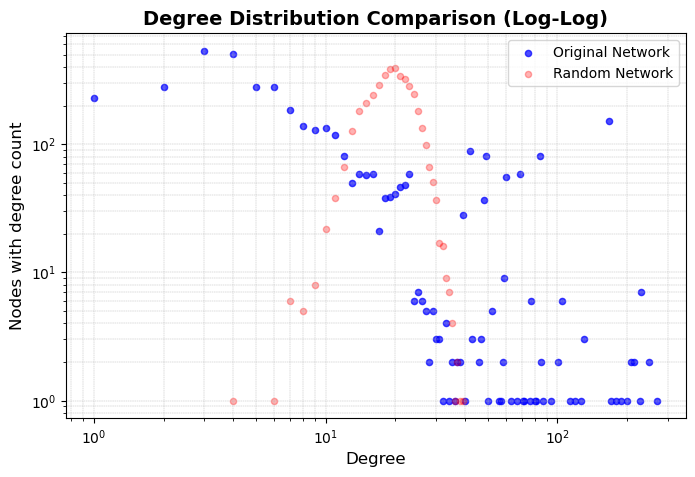

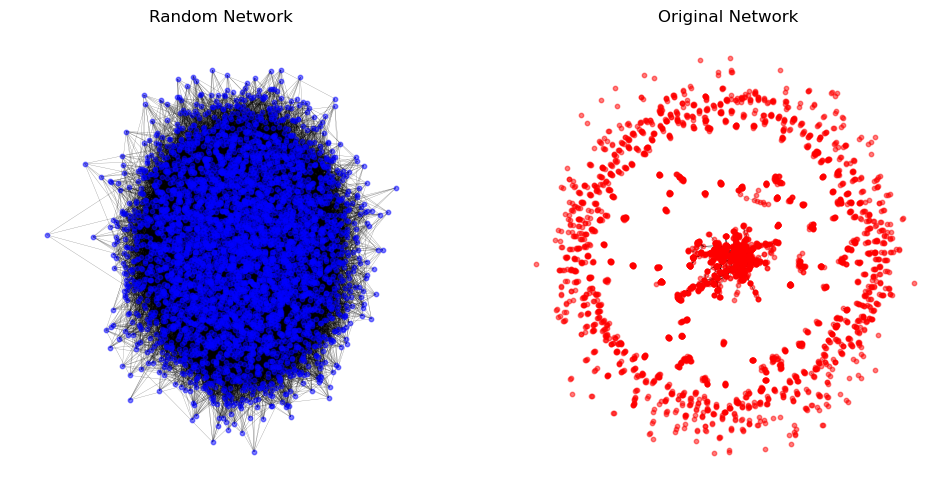

In [ ]:
#plots for the Danish Musicians network:
scatter_dist(M, F_musicians)
plot_2graphs(M, F_musicians)

We see a big diffence between the random and Musicians network. The random network is fully connected and in the super-critical regime as k = 20 >> 1. In contrast, the musicians network is disconected, this makes sense because many musicians are solo artist.

___

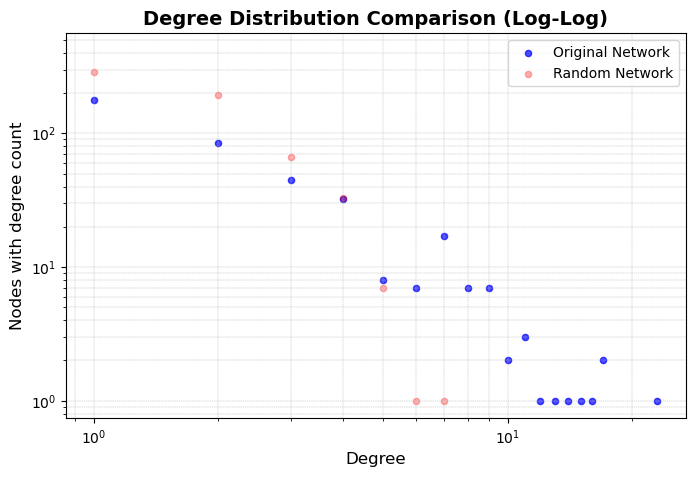

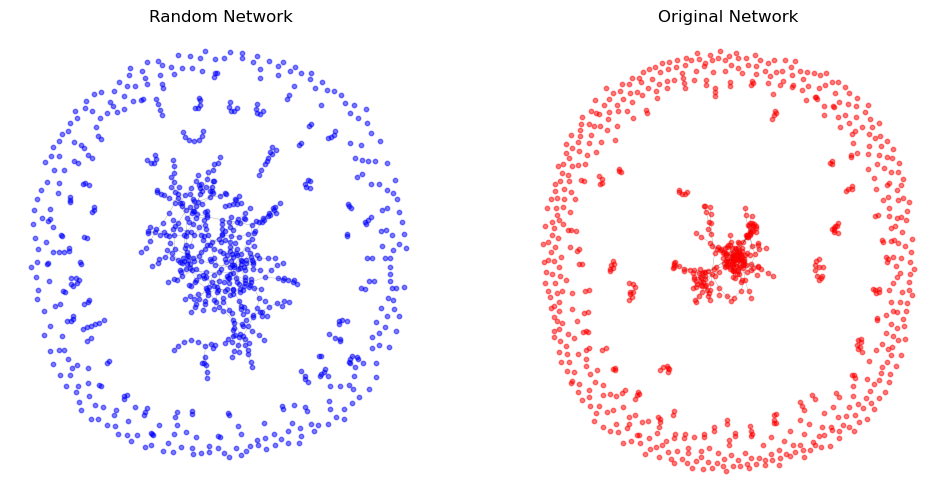

In [22]:
#plots for the DMG network:
scatter_dist(G, F)
plot_2graphs(G, F)

The degree destribution scatter plot suggests that our network follows a heavy tail distribution, as it in a log-log plot nearly follows the diagonal in contrast to the random network. Also, potential hub nodes emerges in the right corner of the plot.

In [26]:
hubnodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:5]
hubnodes

[('Kansas City Stompers', 23),
 ('Frede Fup', 17),
 ('Lone Kellermann og Rockbandet', 17),
 ('Delta Cross Band', 16),
 ('Gorilla Angreb', 15)]

In the network plot, we see a diffence between the networks. The random network is not fully connected but is in the supercritical regime as k = 1.36 > 1. The DMG network has more disconected nodes and more connected center which corresponds to the scatter plot. It seems resonable that it has more disconnected nodes as it is natural that bands never break up and share musicians with other music groups. To investigate the very connected center, we will try to look only at the giant component.
___

## Indepth network analysis
From now on the focus will only be on the DMG network.

First we will investigate the giant

<span style="color:green"> Tools, theory and analysis. Describe the process of theory to insight

- [ ] <span style="color:green"> Talk about how you've worked with text, including regular expressions, unicode, etc.
- [ ] <span style="color:green"> Describe which network science tools and data analysis strategies you've used, how those network science measures work, and why the tools you've chosen are right for the problem you're solving.
- [ ] <span style="color:green"> How did you use the tools to understand your dataset?


In [28]:
G_components = nx.connected_components(G)
G_largest_component = max(G_components, key=len)
G_giant = G.subgraph(G_largest_component)


F_components = nx.connected_components(F)
F_largest_component = max(F_components, key=len)
F_giant = F.subgraph(F_largest_component)

G_giantN = G_giant.number_of_nodes()
G_giantp = G_giant.number_of_edges() / ((G_giantN*(G_giantN-1))/2)

F_giantN = F_giant.number_of_nodes()
F_giantp = F_giant.number_of_edges() / ((F_giantN*(F_giantN-1))/2)

print(f"Size of giants (DMG,RN): {G_giantN, F_giantN}")
print(f"Average degrees (DMG,RN): {G_giantp*(G_giantN - 1), F_giantp*(F_giantN - 1)}")

Size of giants (DMG,RN): (202, 403)
Average degrees (DMG,RN): (4.0, 2.064516129032258)


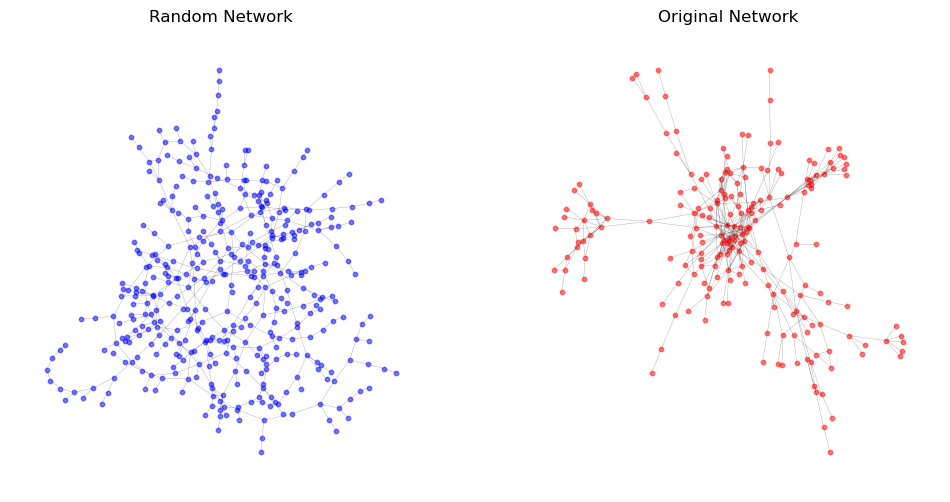

In [29]:
plot_2graphs(G_giant, F_giant)

Looking at the plot, the DMG network does not appear random. This encourage us to investigate the possibility of communities and the small-world property.

### Small-world property

We will in this section look at the giant component, which somewhat corresponds to the largest community of connected

In [ ]:
# Calculate the average shortest path length within the giant:
shortest_G = nx.average_shortest_path_length(G_giant,None)
shortest_F = nx.average_shortest_path_length(F_giant,None)

print(f"Average shortest path length for the giant in RN: {shortest_F}")
print(f"Average shortest path lenght for the giant in DMG: {shortest_G}")

In [ ]:
clustering_G = nx.average_clustering(G_giant)
clustering_F = nx.average_clustering(F_giant)

print(f"Clustering coefficient for the giant in RN: {clustering_F}")
print(f"Clustering coefficient for the giant in DMG: {clustering_G}")

The DMG giant has an average shortest path of 5.5, which means that, on average, there is a maximum of around six links between two music groups. This is more than half the average shortest path in the random network. This is an atypical result ($L_{real}$ > $L_{random}$) and might be due to few highly musician sharing groups - hub nodes (one potential hub nodes discovered below the scatter plot). However this might not exclude that the network may still have small-world properties. The clustering coefficients indicate significantly higher clustering than the random network, which is a key characteristic of small-world networks. All togehter, this suggests that the DMG network, may possess small-world characteristics.

It is a very interesting insight. The bands in the giant tend to cluster strongly and might have hub tendencies. To follow up, we will now try to understand the character of the clusters in network.

### Assortativity

In [ ]:
assortativity_G = nx.degree_assortativity_coefficient(G)
assortativity_F = nx.degree_assortativity_coefficient(F)

print(f"Assortativity coefficient for RN: {assortativity_F}")
print(f"Assortativity coefficient for the DMG network: {assortativity_G}")

So, the DMG network has a high assortiativity, which suggest that high-degree music groups are more likely to connect to other high-degree groups. This may suggest genre-based clustering.

Genres were found by hardcoded approach. With different spellings, we searched the intro texts of the wikipedia articles.

To examine the categorical assortativity using genre, we have to take into account that groups have assigned multiple non-sorted genres. This means we might have to use similarities of the genres between two music groups to get a satisfactorily interpretable result. For this we use jaccard similarity. However, this is now formally not a assortativity measure as a jaccard similarity ranges from 0 to 1. Thereby the average jaccard between linked nodes will also have the same range. So:

Average similarity = 0: All connected music groups has different genres.\
Average similarity = 1: All connected music groups has the same set of genres.

In [ ]:
df_groups = pd.read_csv("data/groups_wMembers_Text_Genres.csv")

genres_dict = dict(zip(df_groups["title"], df_groups["genres"]))

nx.set_node_attributes(G, genres_dict, name="genre")

In [ ]:
def g2set(g1_raw):
    # Convert string to actual list if needed
    if isinstance(g1_raw, str):
        try:
            g1 = ast.literal_eval(g1_raw)
        except (ValueError, SyntaxError):
            g1 = []
    else:
        g1 = g1_raw  # Already a list

    return set(map(str.strip, g1))

def genre_overlap(g1, g2):
    set1 = g2set(g1)
    set2 = g2set(g2)
    return len(set1 & set2) / len(set1 | set2) if len(set1 | set2) else 0 # Jaccard similarity

# Average genre similarity across all edges
total = 0
count = 0
for u, v in G.edges():
    genre_u = G.nodes[u].get("genre")
    genre_v = G.nodes[v].get("genre")
    if genre_u and genre_v:
        sim = genre_overlap(genre_u, genre_v)
        total += sim
        count += 1

avg_similarity = total / count if count else 0
print(f"Average genre similarity between connected groups: {avg_similarity}")

In [ ]:
# for comparison, we can also calculate the average genre similarity for all nodes:
total_sim = 0
count = 0

for u, v in combinations(G.nodes(), 2):  # All unique pairs
    genre_u = G.nodes[u].get("genre")
    genre_v = G.nodes[v].get("genre")

    if genre_u and genre_v:
        sim =  genre_overlap(genre_u, genre_v)
        total_sim += sim
        count += 1

avg_global_jaccard = total_sim / count if count else 0
print(f"Average global Jaccard similarity (all node pairs): {avg_global_jaccard}")

In [ ]:
groupsG = G.copy()
groupsG.remove_nodes_from(list(nx.isolates(groupsG)))


def plotNetwork_color(G):
    #Genre hierarchy
    hierarchy = ["eurovision pop", "jazz", "choral", "classical", "heavy metal", "country", "electronic", "folk" , "pop", "rock"]
    # the hierarchy is defined in a way that the most common genres pop and rock are at the end of the list

    def pick_genre(genres_raw):
        if isinstance(genres_raw, str):
            try:
                genres = ast.literal_eval(genres_raw)
            except (ValueError, SyntaxError):
                genres = []
        else:
            genres = genres_raw or []

        genres_lower = [g.lower().strip() for g in genres]

        for genre in hierarchy:
            if genre in genres_lower:
                return genre
        return "other"


    genre_map = {node: pick_genre(G.nodes[node].get("genre")) for node in G.nodes()}


    unique_genres = sorted(set(genre_map.values()))

    color_map = {genre: plt.cm.tab10(i % 10) for i, genre in enumerate(unique_genres)}

    #NOTE: is the right genre swapped??
    color_map["other"], color_map["jazz"] = color_map["jazz"], color_map["other"]

    node_colors = [color_map[genre_map[node]] for node in G.nodes()]


    # Plot the graph
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(12, 9))

    nx.draw(
        G,
        pos,
        node_color=node_colors,
        with_labels=False,
        node_size=50,
        edge_color='gray'
    )

    # Create a legend as a table
    legend_elements = [Patch(facecolor=color_map[genre], label=genre) for genre in unique_genres]
    plt.legend(handles=legend_elements, title="Genre (Color)", loc="upper right", bbox_to_anchor=(1.15, 1.0))

    plt.title("Network Colored by Representative Genre")
    plt.tight_layout()
    plt.show()

plotNetwork_color(groupsG)
plotNetwork_color(G_giant)

From the similarity average and global similarity average we se a significantly higher similarity between connected nodes. So, music groups more often link with music groups with similar sets of genres. This indicates that communities tend to share the same genres, which makes sense as a rock musician might no be able to play in a classical orcestra also. Looking at the colored plot of the giant of the DMG network, we see an isolated cluster in the buttom consisting mostly of the genres "classical" and "choral", which are rather similar genres. In the very connected middle the genres "rock", "pop" and "jazz" seem to be dominant.

## Discussion

<span style="color:green"> Discussion. Think critically about your creation
- [ ] <span style="color:green"> What went well?
- [ ] <span style="color:green"> What is still missing? What could be improved? Why?
